# Portfolio Optimization

## Extract Historical Performance

In [2]:
# Import packages
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as sci_opt

### Select securities and check for amount of history available

In [3]:
# List of securities
securities = ['TECB', 'SCHE', 'SCHF', 'SCHV', 'SCHG', 'KOMP', 'MDYG', 'MDYV', 'SLYG', 'SLYV', 'OSMAX', 'USMV', 'SBSPX', 'VOO', '^GSPC']

# Init Dataframe
df_min_date = pd.DataFrame(columns=['Min Date'])

# Capture the closing price for each security and add to dataframe
for security in securities:
    min_date = min(yf.Ticker(security).history(period='max').index)
    min_date_df = pd.DataFrame([min_date], columns=['Min Date'])
    df_min_date = pd.concat([df_min_date, min_date_df], ignore_index=True)

df_min_date.index = securities  # Assign securities as index after appending all rows

# Calculate the date 10 years ago from today, making it timezone-aware to match the DataFrame's timezone
ten_years_ago = pd.Timestamp(datetime.now() - timedelta(days=365*10)).tz_localize('America/New_York')

# Add a new column to indicate if the 'Min Date' is over 10 years from today
df_min_date['Over 10 Years'] = df_min_date['Min Date'] < ten_years_ago

df_min_date

C:\Users\sean1\AppData\Local\Temp\ipykernel_21812\834341146.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_min_date = pd.concat([df_min_date, min_date_df], ignore_index=True)


,Min Date,Over 10 Years
TECB,2020-01-13 00:00:00-05:00,False
SCHE,2010-01-14 00:00:00-05:00,True
SCHF,2009-11-03 00:00:00-05:00,True
SCHV,2009-12-15 00:00:00-05:00,True
SCHG,2010-01-04 00:00:00-05:00,True
KOMP,2018-10-23 00:00:00-04:00,False
MDYG,2005-11-15 00:00:00-05:00,True
MDYV,2005-11-15 00:00:00-05:00,True
SLYG,2000-10-02 00:00:00-04:00,True
SLYV,2000-10-02 00:00:00-04:00,True


### Pull from Yahoo Finance package historical data

In [4]:
# Init Dataframe
df = pd.DataFrame()

# Capture the closing price for each security and add to dataframe
for security in securities:
    if df_min_date.loc[security, 'Over 10 Years']:
        df[security] = yf.Ticker(security).history(start='2014-01-01', end=datetime.now().date().strftime("%Y-%m-%d")).Close
    


### EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2570 entries, 2014-01-02 00:00:00-05:00 to 2024-03-19 00:00:00-04:00
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SCHE    2570 non-null   float64
 1   SCHF    2570 non-null   float64
 2   SCHV    2570 non-null   float64
 3   SCHG    2570 non-null   float64
 4   MDYG    2570 non-null   float64
 5   MDYV    2570 non-null   float64
 6   SLYG    2570 non-null   float64
 7   SLYV    2570 non-null   float64
 8   OSMAX   2570 non-null   float64
 9   USMV    2570 non-null   float64
 10  SBSPX   2570 non-null   float64
 11  VOO     2570 non-null   float64
 12  ^GSPC   2570 non-null   float64
dtypes: float64(13)
memory usage: 281.1 KB


In [6]:
df.head()

,SCHE,SCHF,SCHV,SCHG,MDYG,MDYV,SLYG,SLYV,OSMAX,USMV,SBSPX,VOO,^GSPC
Date,,,,,,,,,,,,,
2014-01-02 00:00:00-05:00,18.038139,23.579515,31.019407,20.609753,31.882498,30.555965,35.346085,37.864632,21.830843,29.024481,12.422215,140.151825,1831.979980
2014-01-03 00:00:00-05:00,18.015392,23.579515,31.065525,20.573029,32.081688,30.743725,35.514286,38.037193,21.959059,29.016224,12.415477,140.026443,1831.369995
2014-01-06 00:00:00-05:00,17.856159,23.556669,31.011715,20.481201,31.798779,30.649847,35.159901,37.641693,21.986057,28.950169,12.381794,139.675247,1826.770020
2014-01-07 00:00:00-05:00,17.931984,23.655676,31.157774,20.651073,31.986423,30.857191,35.522282,38.030018,22.019798,29.115316,12.455896,140.544800,1837.880005
2014-01-08 00:00:00-05:00,17.878912,23.625214,31.096275,20.678621,32.006641,30.919775,35.460224,37.850227,22.033295,29.107058,12.462632,140.603302,1837.489990


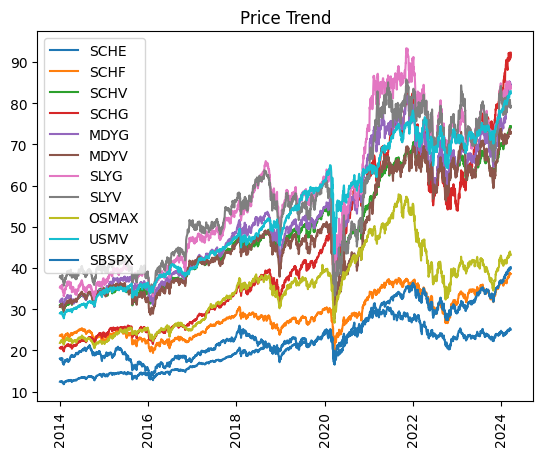

In [7]:
# Plot the close prices
plt.figure()
plt.plot(df.iloc[:,:-2]) # Excluded S&P 500 because of scale
plt.title('Price Trend')
plt.legend(df.columns)
plt.xticks(rotation=90)
plt.show()

### Correlations

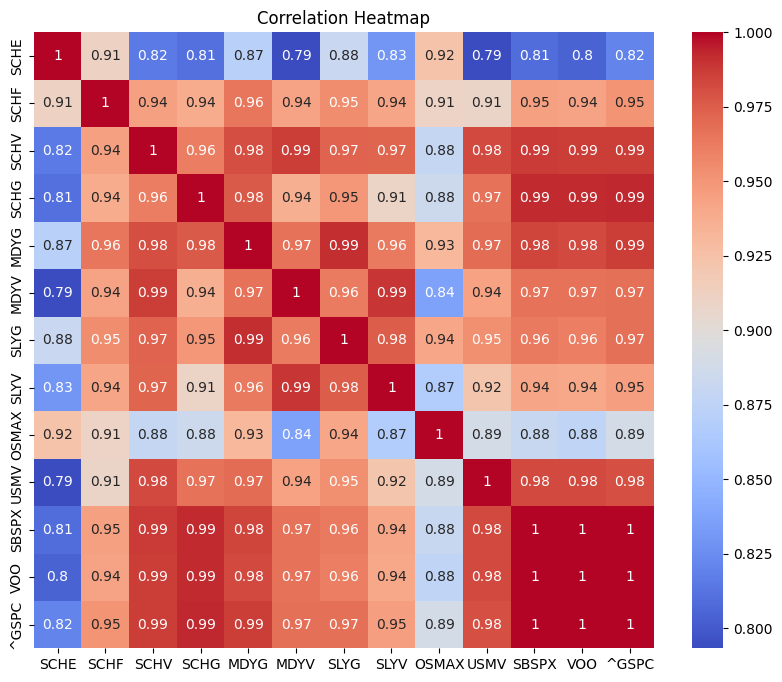

In [8]:
# Measure the correlation
import seaborn as sns

# Create a correlation matrix
corr_matrix = df.corr()

# Set the figure size
plt.figure(figsize=(10, 8))

# Create a heatmap using the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

# Set the title of the plot
plt.title('Correlation Heatmap')

# Show the plot
plt.show()



In [9]:
df.describe()

,SCHE,SCHF,SCHV,SCHG,MDYG,MDYV,SLYG,SLYV,OSMAX,USMV,SBSPX,VOO,^GSPC
count,2570.000000,2570.000000,2570.000000,2570.000000,2570.000000,2570.000000,2570.000000,2570.000000,2570.000000,2570.000000,2570.000000,2570.000000,2570.000000
mean,21.998719,28.218118,48.768834,44.520547,52.104947,47.850794,57.688385,56.828578,34.843708,53.202748,22.479764,260.666153,3046.973556
std,3.627025,4.790527,12.470261,19.720862,14.685688,12.820403,16.808861,14.959504,9.184655,15.376847,7.705904,92.968615,935.135810
min,13.685315,19.393904,29.328136,19.787935,30.511232,27.713686,32.416283,33.298428,20.555408,27.810658,11.815925,133.446503,1741.890015
25%,19.276198,24.036729,36.714716,25.758927,37.792903,35.964212,40.702816,41.794597,25.363438,38.766526,15.034080,171.385834,2130.129944
50%,22.142753,27.706058,46.951279,38.195210,50.301958,45.000599,56.440233,54.810211,35.855331,51.578409,20.518126,236.727203,2815.530029
75%,23.977329,32.320146,62.366226,62.070892,66.573921,62.333746,72.430164,72.088140,40.524818,69.143885,30.132267,354.129822,3951.525024
max,31.504101,38.810001,74.459999,92.260002,85.314896,73.820946,93.331573,85.785995,57.892086,82.879997,40.169998,475.600006,5178.509766


## Calculate Sharpe Ratios

In [10]:
# Calculate Daily Simple returns
daily_simple_returns = df.pct_change()

daily_simple_returns


,SCHE,SCHF,SCHV,SCHG,MDYG,MDYV,SLYG,SLYV,OSMAX,USMV,SBSPX,VOO,^GSPC
Date,,,,,,,,,,,,,
2014-01-02 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-03 00:00:00-05:00,-0.001261,0.000000,0.001487,-0.001782,0.006248,0.006145,0.004759,0.004557,0.005873,-0.000284,-0.000542,-0.000895,-0.000333
2014-01-06 00:00:00-05:00,-0.008839,-0.000969,-0.001732,-0.004463,-0.008818,-0.003054,-0.009979,-0.010398,0.001229,-0.002276,-0.002713,-0.002508,-0.002512
2014-01-07 00:00:00-05:00,0.004246,0.004203,0.004710,0.008294,0.005901,0.006765,0.010307,0.010316,0.001535,0.005705,0.005985,0.006226,0.006082
2014-01-08 00:00:00-05:00,-0.002960,-0.001288,-0.001974,0.001334,0.000632,0.002028,-0.001747,-0.004728,0.000613,-0.000284,0.000541,0.000416,-0.000212
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-13 00:00:00-04:00,-0.003929,0.000516,0.002153,-0.004010,0.005427,0.001895,0.002607,0.000124,-0.006135,-0.001329,-0.001744,-0.001516,-0.001925
2024-03-14 00:00:00-04:00,-0.004734,-0.007472,-0.006581,0.000109,-0.010091,-0.014322,-0.012411,-0.016739,-0.007316,-0.003509,-0.002746,-0.002193,-0.002871
2024-03-15 00:00:00-04:00,-0.003171,-0.000519,-0.001352,-0.010990,-0.002845,0.001645,0.003351,0.005044,-0.001612,-0.002064,-0.006508,-0.006888,-0.006483


In [11]:
# Calcuate the annualized returns
annualized_returns = daily_simple_returns.mean() * 252 # 252 is the average number of trading days in a year

# Calculate the Standard Deviation
risk_std = daily_simple_returns.std() * np.sqrt(252)


# Calculate the Sharpe Ratio
sharpe_ratio = annualized_returns / risk_std

# Combine the results
simulations_data = [annualized_returns, risk_std, sharpe_ratio]

# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
print('')
print('='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df)
print('-'*80)


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
        Returns  Volatility  Sharpe Ratio
SCHE   0.052171    0.198684      0.262584
SCHF   0.062714    0.169321      0.370383
SCHV   0.100119    0.168544      0.594024
SCHG   0.167819    0.203542      0.824494
MDYG   0.115767    0.200171      0.578342
MDYV   0.107923    0.211367      0.510593
SLYG   0.109171    0.218920      0.498677
SLYV   0.098909    0.228971      0.431974
OSMAX  0.080708    0.165390      0.487987
USMV   0.113545    0.145330      0.781291
SBSPX  0.130740    0.176212      0.741950
VOO    0.135423    0.175946      0.769686
^GSPC  0.117551    0.176275      0.666861
--------------------------------------------------------------------------------


In [12]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

# S&P 500 Metrics
sp500 = simulations_df.loc[simulations_df.index=='^GSPC']

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)

print('')
print('='*80)
print('S&P 500:')
print('-'*80)
print(sp500)
print('-'*80)




MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns         0.167819
Volatility      0.203542
Sharpe Ratio    0.824494
Name: SCHG, dtype: float64
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns         0.113545
Volatility      0.145330
Sharpe Ratio    0.781291
Name: USMV, dtype: float64
--------------------------------------------------------------------------------

S&P 500:
--------------------------------------------------------------------------------
        Returns  Volatility  Sharpe Ratio
^GSPC  0.117551    0.176275      0.666861
--------------------------------------------------------------------------------


C:\Users\sean1\AppData\Local\Temp\ipykernel_21812\1082289826.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[1],
C:\Users\sean1\AppData\Local\Temp\ipykernel_21812\1082289826.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[0],
C:\Users\sean1\AppData\Local\Temp\ipykernel_21812\1082289826.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(max_sharpe_ratio[1],
C:\Users\sean1\AppData

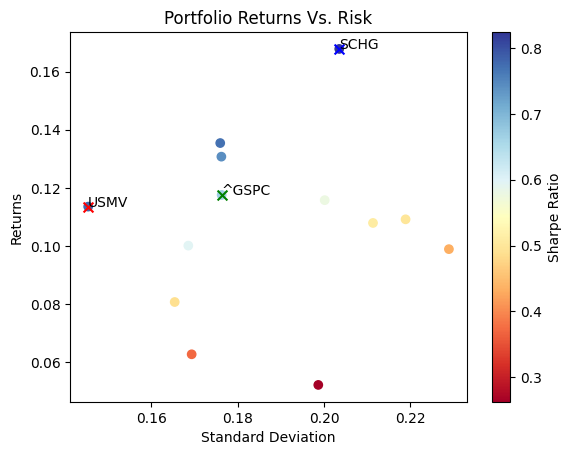

In [13]:
# Risk & Return Graph
plt.scatter(y=annualized_returns, x=risk_std, c=sharpe_ratio, cmap='RdYlBu')

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker="x",
    color='b',
    s=50
)
plt.text(max_sharpe_ratio[1],
    max_sharpe_ratio[0],max_sharpe_ratio.name)


# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker="x",
    color='r',
    s=50
)
plt.text(min_volatility[1],
    min_volatility[0],min_volatility.name)

# Plot the S&P 500, using a `Green Star`.
plt.scatter(
    sp500.iloc[:,1],
    sp500.iloc[:,0],
    marker='x',
    color='g',
    s=50
)
plt.text(sp500.iloc[:,1],
    sp500.iloc[:,0],sp500.index.values[0])

# Finally, show the plot.
plt.show()

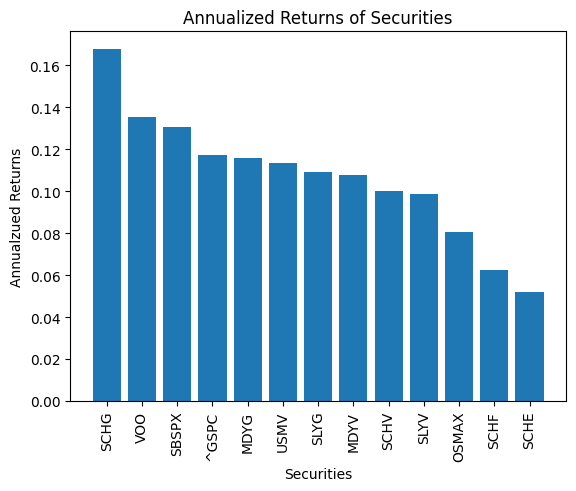

In [14]:
# Sort descending
annualized_returns = annualized_returns.sort_values(ascending=False)

# Plot
plt.bar(annualized_returns.index, annualized_returns)
plt.ylabel('Annualzued Returns')
plt.xlabel('Securities')
plt.title('Annualized Returns of Securities')
plt.xticks(rotation = 90)
plt.show()

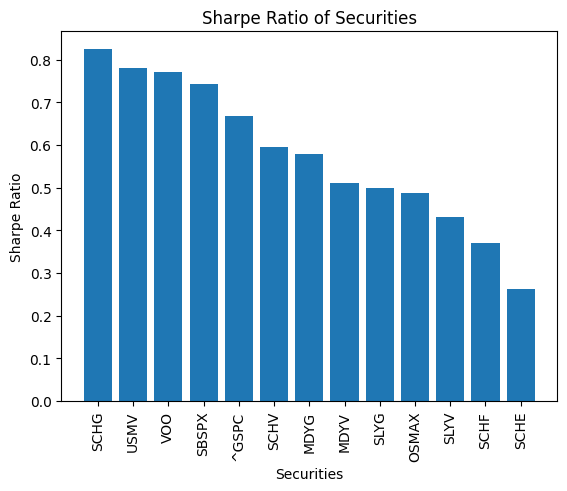

In [15]:
# Sort descending
sharpe_ratio = sharpe_ratio.sort_values(ascending=False)

# Plot
plt.bar(sharpe_ratio.index, sharpe_ratio)
plt.ylabel('Sharpe Ratio')
plt.xlabel('Securities')
plt.title('Sharpe Ratio of Securities')
plt.xticks(rotation = 90)
plt.show()

## Calculate Portfolio Expected Value
This code is from [Sigma Coding](https://www.youtube.com/c/SigmaCoding).
https://github.com/areed1192/portfolio-optimization.git

In [16]:
# Define portfolio only with ETFs
symbols = df.columns[:-2] # Drop the S&P 500 Index
price_data_frame = df[symbols]

# of symbols we have, so let's save some time and just calculate that now.
number_of_symbols = len(symbols)
print(f'The portfolio has {number_of_symbols} ETFs to select from.')



The portfolio has 11 ETFs to select from.


In [17]:
# Calculate the Log of returns.
#log_return = np.log(1 + price_data_frame.pct_change())
log_return = price_data_frame.pct_change() # Test without log

# Generate Random Weights.
random_weights = np.array(np.random.random(number_of_symbols))

# Generate the Rebalance Weights, these should equal 1.
rebalance_weights = random_weights / np.sum(random_weights)

# Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)

# Calculate the Expected Volatility, annualize it by multiplying it by `252`.
exp_vol = np.sqrt(
np.dot(
    rebalance_weights.T,
    np.dot(
        log_return.cov() * 252,
        rebalance_weights
    )
)
)

# Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol

# Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

# Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
    random_weights  rebalance_weights
0         0.602419           0.123466
1         0.512859           0.105111
2         0.761857           0.156143
3         0.021994           0.004508
4         0.000926           0.000190
5         0.464756           0.095252
6         0.354192           0.072592
7         0.175563           0.035982
8         0.885852           0.181555
9         0.669402           0.137194
10        0.429419           0.088009
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  \
0                    0.092945                       0.162183   

   Portfolio Sharpe Ratio  
0                0.573088  
----------------------------------------------------------------------------

## Portfolio Optimization

### Monte Carlo

In [18]:
# Initialize the components, to run a Monte Carlo Simulation.

# We will run 5000 iterations.
num_of_portfolios = 5000

# Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
all_weights = np.zeros((num_of_portfolios, number_of_symbols))

# Prep an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(num_of_portfolios)

# Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(num_of_portfolios)

# Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(num_of_portfolios)

# Start the simulations.
for ind in range(num_of_portfolios):

    # First, calculate the weights.
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    # Add the weights, to the `weights_arrays`.
    all_weights[ind, :] = weights

    # Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)

    # Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

# Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio
simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]

# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
print('')
print('='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df.head())
print('-'*80)


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio  \
0  0.103099    0.173261      0.595052   
1  0.098366    0.177380      0.554552   
2  0.095687    0.172513      0.554663   
3  0.101256    0.167708      0.603762   
4  0.101819    0.172343      0.590794   

                                   Portfolio Weights  
0  [0.19194780157867075, 0.03174446201264438, 0.2...  
1  [0.19095670291800534, 0.011523601967847867, 0....  
2  [0.14024724418063353, 0.10802568619978974, 0.0...  
3  [0.1712837473719471, 0.16162067989755705, 0.03...  
4  [0.10228551184341886, 0.12852797814624173, 0.1...  
--------------------------------------------------------------------------------


In [19]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]


# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns                                                       0.118402
Volatility                                                    0.167452
Sharpe Ratio                                                  0.707078
Portfolio Weights    [0.002140990668976316, 0.00030196122426823387,...
Name: 1649, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns                                                       0.096106
Volatility                                                    0.156703
Sharpe Ratio                                                  0.613296
Portfolio Weights    [0.08820834731382848, 0.18951222143632518, 0.0...
Name: 1200, dtype: object
--------------------------------------------------------------------------------


C:\Users\sean1\AppData\Local\Temp\ipykernel_21812\563608600.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[1],
C:\Users\sean1\AppData\Local\Temp\ipykernel_21812\563608600.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_sharpe_ratio[0],
C:\Users\sean1\AppData\Local\Temp\ipykernel_21812\563608600.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  min_volatility[1],
C:\Users\sean1\AppData\Local\Temp\ip

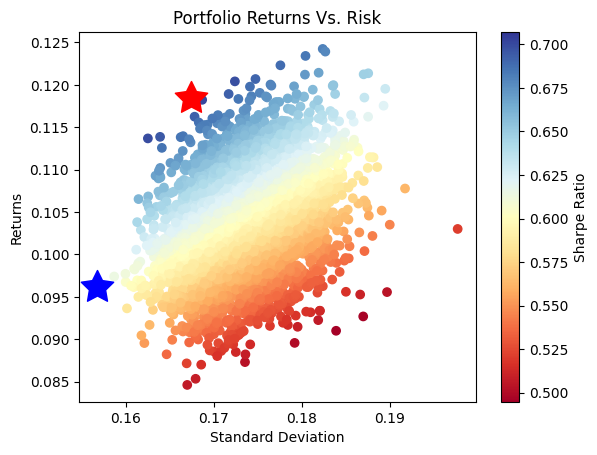

In [20]:
# This is so I can see the plot inside of my Jupyter Notebook.
%matplotlib inline

# Plot the data on a Scatter plot.
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

# Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

# Finally, show the plot.
plt.show()

### Scipy Optimization

In [21]:
def get_metrics(weights: list) -> np.array:
    """
    ### Overview:
    ----
    With a given set of weights, return the portfolio returns,
    the portfolio volatility, and the portfolio sharpe ratio.

    ### Arguments:
    ----
    weights (list): An array of portfolio weights.

    ### Returns:
    ----
    (np.array): An array containg return value, a volatility value,
        and a sharpe ratio.
    """

    # Convert to a Numpy Array.
    weights = np.array(weights)

    # Calculate the returns, remember to annualize them (252).
    ret = np.sum(log_return.mean() * weights) * 252

    # Calculate the volatility, remember to annualize them (252).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio.
    sr = ret / vol

    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[2] * -1

def grab_volatility(weights: list) -> np.array:
    """The function used to minimize the Sharpe Ratio.

    ### Arguments:
    ----
    weights (list): The weights, we are testing to see
        if it's the minimum.

    ### Returns:
    ----
    (np.array): An numpy array of the portfolio metrics.
    """
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    """Ensure the allocations of the "weights", sums to 1 (100%)

    ### Arguments:
    ----
    weights (list): The weights we want to check to see
        if they sum to 1.

    ### Returns:
    ----
    float: The different between 1 and the sum of the weights.
    """
    return np.sum(weights) - 1

In [22]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.8388678124086645
       x: [ 0.000e+00  7.738e-17  0.000e+00  5.850e-01  0.000e+00
            0.000e+00  1.358e-16  1.182e-16  0.000e+00  4.150e-01
            6.122e-16]
     nit: 8
     jac: [ 3.952e-01  3.176e-01  1.515e-01 -1.401e-05  2.055e-01
            1.969e-01  2.556e-01  2.474e-01  1.585e-01  1.974e-05
            8.250e-02]
    nfev: 96
    njev: 8
--------------------------------------------------------------------------------


In [23]:
# Grab the metrics.
optimized_max_sharpe_metrics = get_metrics(weights=optimized_sharpe.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_max_sharpe_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[0.00000000e+00 7.73842257e-17 0.00000000e+00 5.84971571e-01
 0.00000000e+00 0.00000000e+00 1.35842262e-16 1.18165857e-16
 0.00000000e+00 4.15028429e-01 6.12170843e-16]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.14529399 0.17320249 0.83886781]
--------------------------------------------------------------------------------


In [24]:
# Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

# Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

# We need to create an initial guess to start with,
# and usually the best initial guess is just an
# even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_volatility = sci_opt.minimize(
    grab_volatility, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

# Print the results.
print('')
print('='*80)
print('OPTIMIZED VOLATILITY RATIO:')
print('-'*80)
print(optimized_volatility)
print('-'*80)


OPTIMIZED VOLATILITY RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.14106176722648642
       x: [ 5.509e-17  7.470e-17  0.000e+00  2.427e-17  0.000e+00
            0.000e+00  0.000e+00  0.000e+00  2.882e-01  7.118e-01
            6.409e-17]
     nit: 12
     jac: [ 1.441e-01  1.490e-01  1.562e-01  1.801e-01  1.772e-01
            1.744e-01  1.806e-01  1.738e-01  1.411e-01  1.411e-01
            1.664e-01]
    nfev: 144
    njev: 12
--------------------------------------------------------------------------------


In [25]:
# Grab the metrics.
optimized_min_volatility_metrics = get_metrics(weights=optimized_volatility.x)

# Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_volatility.x)
print('-'*80)


# Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_min_volatility_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[5.50910635e-17 7.46965973e-17 0.00000000e+00 2.42665989e-17
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.88204093e-01 7.11795907e-01 6.40868856e-17]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.10408142 0.14106177 0.7378429 ]
--------------------------------------------------------------------------------


## Evaluate Scenarios

In [26]:
# List the scenarios
scenarios = ['Monte Carlo Max Sharpe', 'Monte Carlo Min Volatility',  'Scipy Max Sharpe', 'Scipy Min Volatility']

# Combine all the scenarios into one dataframe for summary
df_portfolio_metrics_scenarios = pd.DataFrame([max_sharpe_ratio[:3].values, min_volatility[:3].values, optimized_max_sharpe_metrics, optimized_min_volatility_metrics], index=scenarios, columns=simulations_df.columns[:3]).reset_index().rename(columns={'index' : 'Scenario'})
df_portfolio_weights_scenarios = pd.DataFrame([max_sharpe_ratio[3], min_volatility[3], optimized_sharpe.x, optimized_volatility.x], columns=symbols, index=scenarios).reset_index().rename(columns={'index' : 'Scenario'})
df_portfolio_metrics_scenarios = df_portfolio_metrics_scenarios.merge(df_portfolio_weights_scenarios, on='Scenario')

# Show scenario results
df_portfolio_metrics_scenarios.round(4)

C:\Users\sean1\AppData\Local\Temp\ipykernel_21812\1545433427.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_portfolio_weights_scenarios = pd.DataFrame([max_sharpe_ratio[3], min_volatility[3], optimized_sharpe.x, optimized_volatility.x], columns=symbols, index=scenarios).reset_index().rename(columns={'index' : 'Scenario'})


,Scenario,Returns,Volatility,Sharpe Ratio,SCHE,SCHF,SCHV,SCHG,MDYG,MDYV,SLYG,SLYV,OSMAX,USMV,SBSPX
0,Monte Carlo Max Sharpe,0.1184,0.1675,0.7071,0.0021,0.0003,0.2284,0.2023,0.1030,0.0126,0.0783,0.0381,0.0734,0.2474,0.0141
1,Monte Carlo Min Volatility,0.0961,0.1567,0.6133,0.0882,0.1895,0.0667,0.0935,0.0207,0.0264,0.0032,0.0243,0.2150,0.2165,0.0560
2,Scipy Max Sharpe,0.1453,0.1732,0.8389,0.0000,0.0000,0.0000,0.5850,0.0000,0.0000,0.0000,0.0000,0.0000,0.4150,0.0000
3,Scipy Min Volatility,0.1041,0.1411,0.7378,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2882,0.7118,0.0000


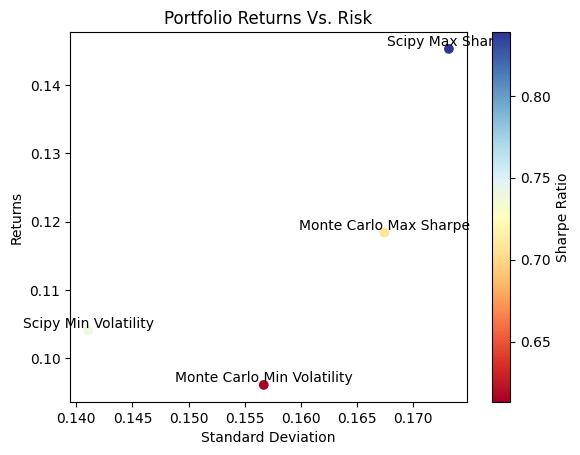

In [27]:
# Plot the Scenarios Risk and Rewards

plt.scatter(data=df_portfolio_metrics_scenarios, x='Volatility', y='Returns', c='Sharpe Ratio', cmap='RdYlBu')


for index, row in df_portfolio_metrics_scenarios.iterrows():
    plt.text(row['Volatility'], row['Returns'], row['Scenario'], va='bottom', ha='center')    

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.show()

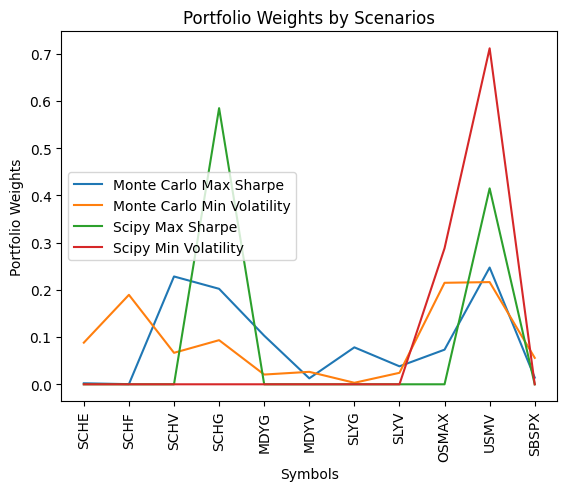

In [28]:
# Plot the Weights for each scenario

plt.plot(df_portfolio_weights_scenarios.iloc[:,1:].T)
plt.title('Portfolio Weights by Scenarios')
plt.xlabel('Symbols')
plt.ylabel('Portfolio Weights')
plt.xticks(rotation=90)
plt.legend(scenarios)
plt.show()
